In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import theano.tensor as tt
from pandas.plotting import register_matplotlib_converters
from pandas_datareader.data import DataReader
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
az.style.use("arviz-darkgrid")

In [3]:
cpi = DataReader("CPIAUCNS", "fred", start="1971-01", end="2018-12")
cpi.index = pd.DatetimeIndex(cpi.index, freq="MS")

# Define the inflation series that we'll use in analysis
inf = np.log(cpi).resample("QS").mean().diff()[1:] * 400
inf = inf.dropna()
print(inf.head())

            CPIAUCNS
DATE                
1971-04-01  4.316424
1971-07-01  4.279518
1971-10-01  1.956799
1972-01-01  2.917767
1972-04-01  3.219096


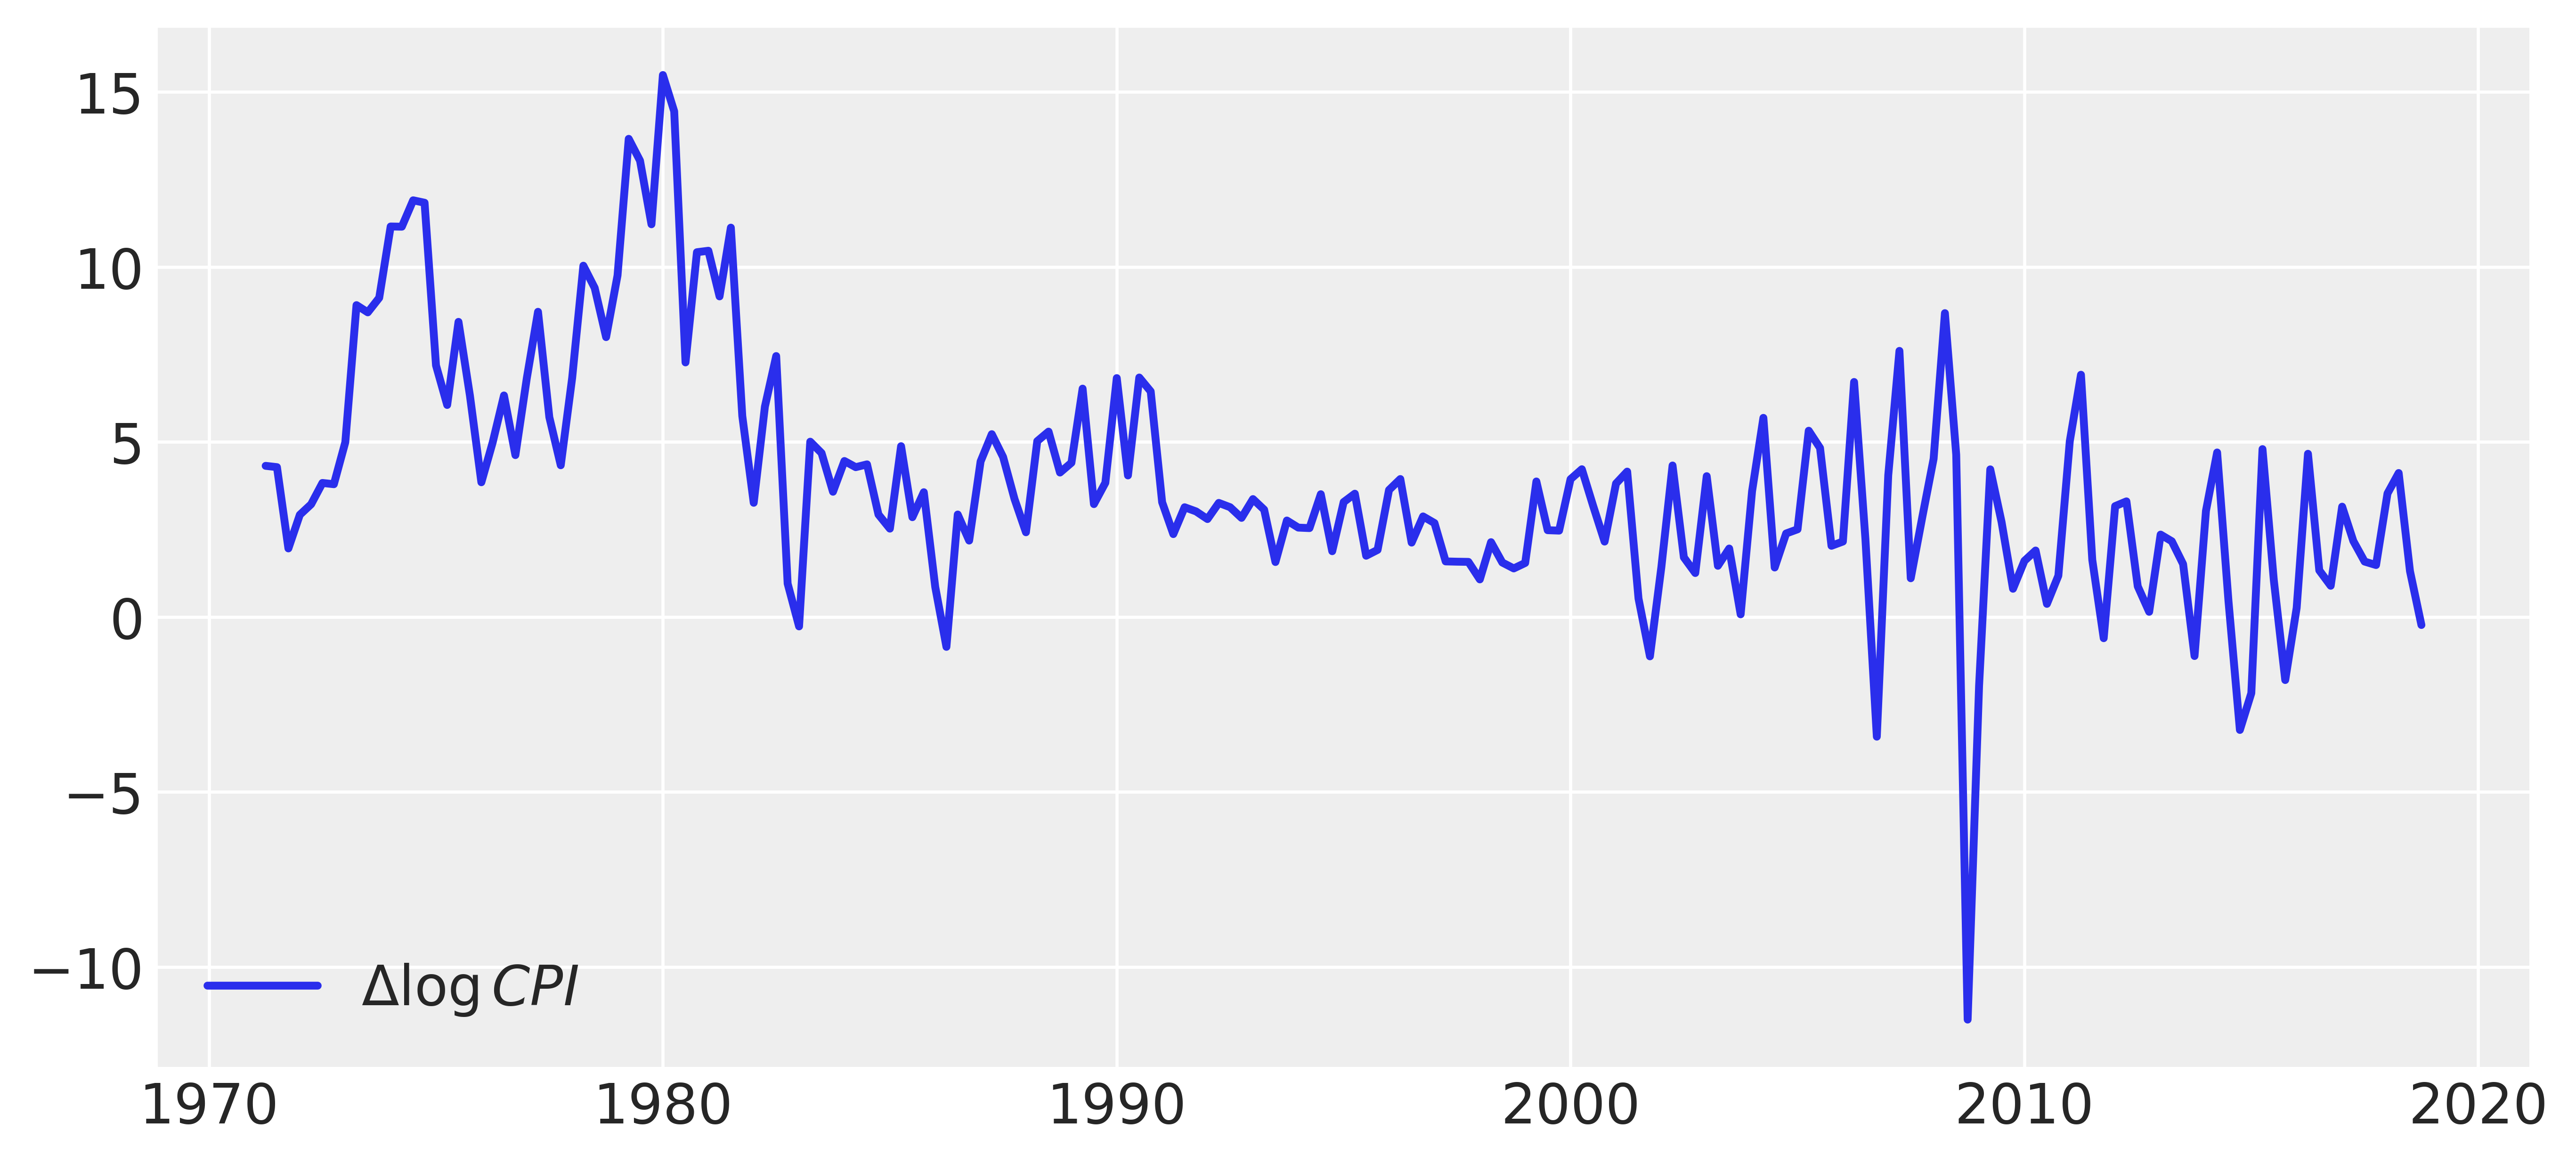

In [4]:
# Plot the series
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r"$\Delta \log CPI$", lw=2)
ax.legend(loc="lower left")
plt.show()

/Users/wang/Library/CloudStorage/GoogleDrive-thetheoryofeverythingcn@gmail.com/My Drive/23 Spring/TimeSeries/Project/Bayesian-inference3/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


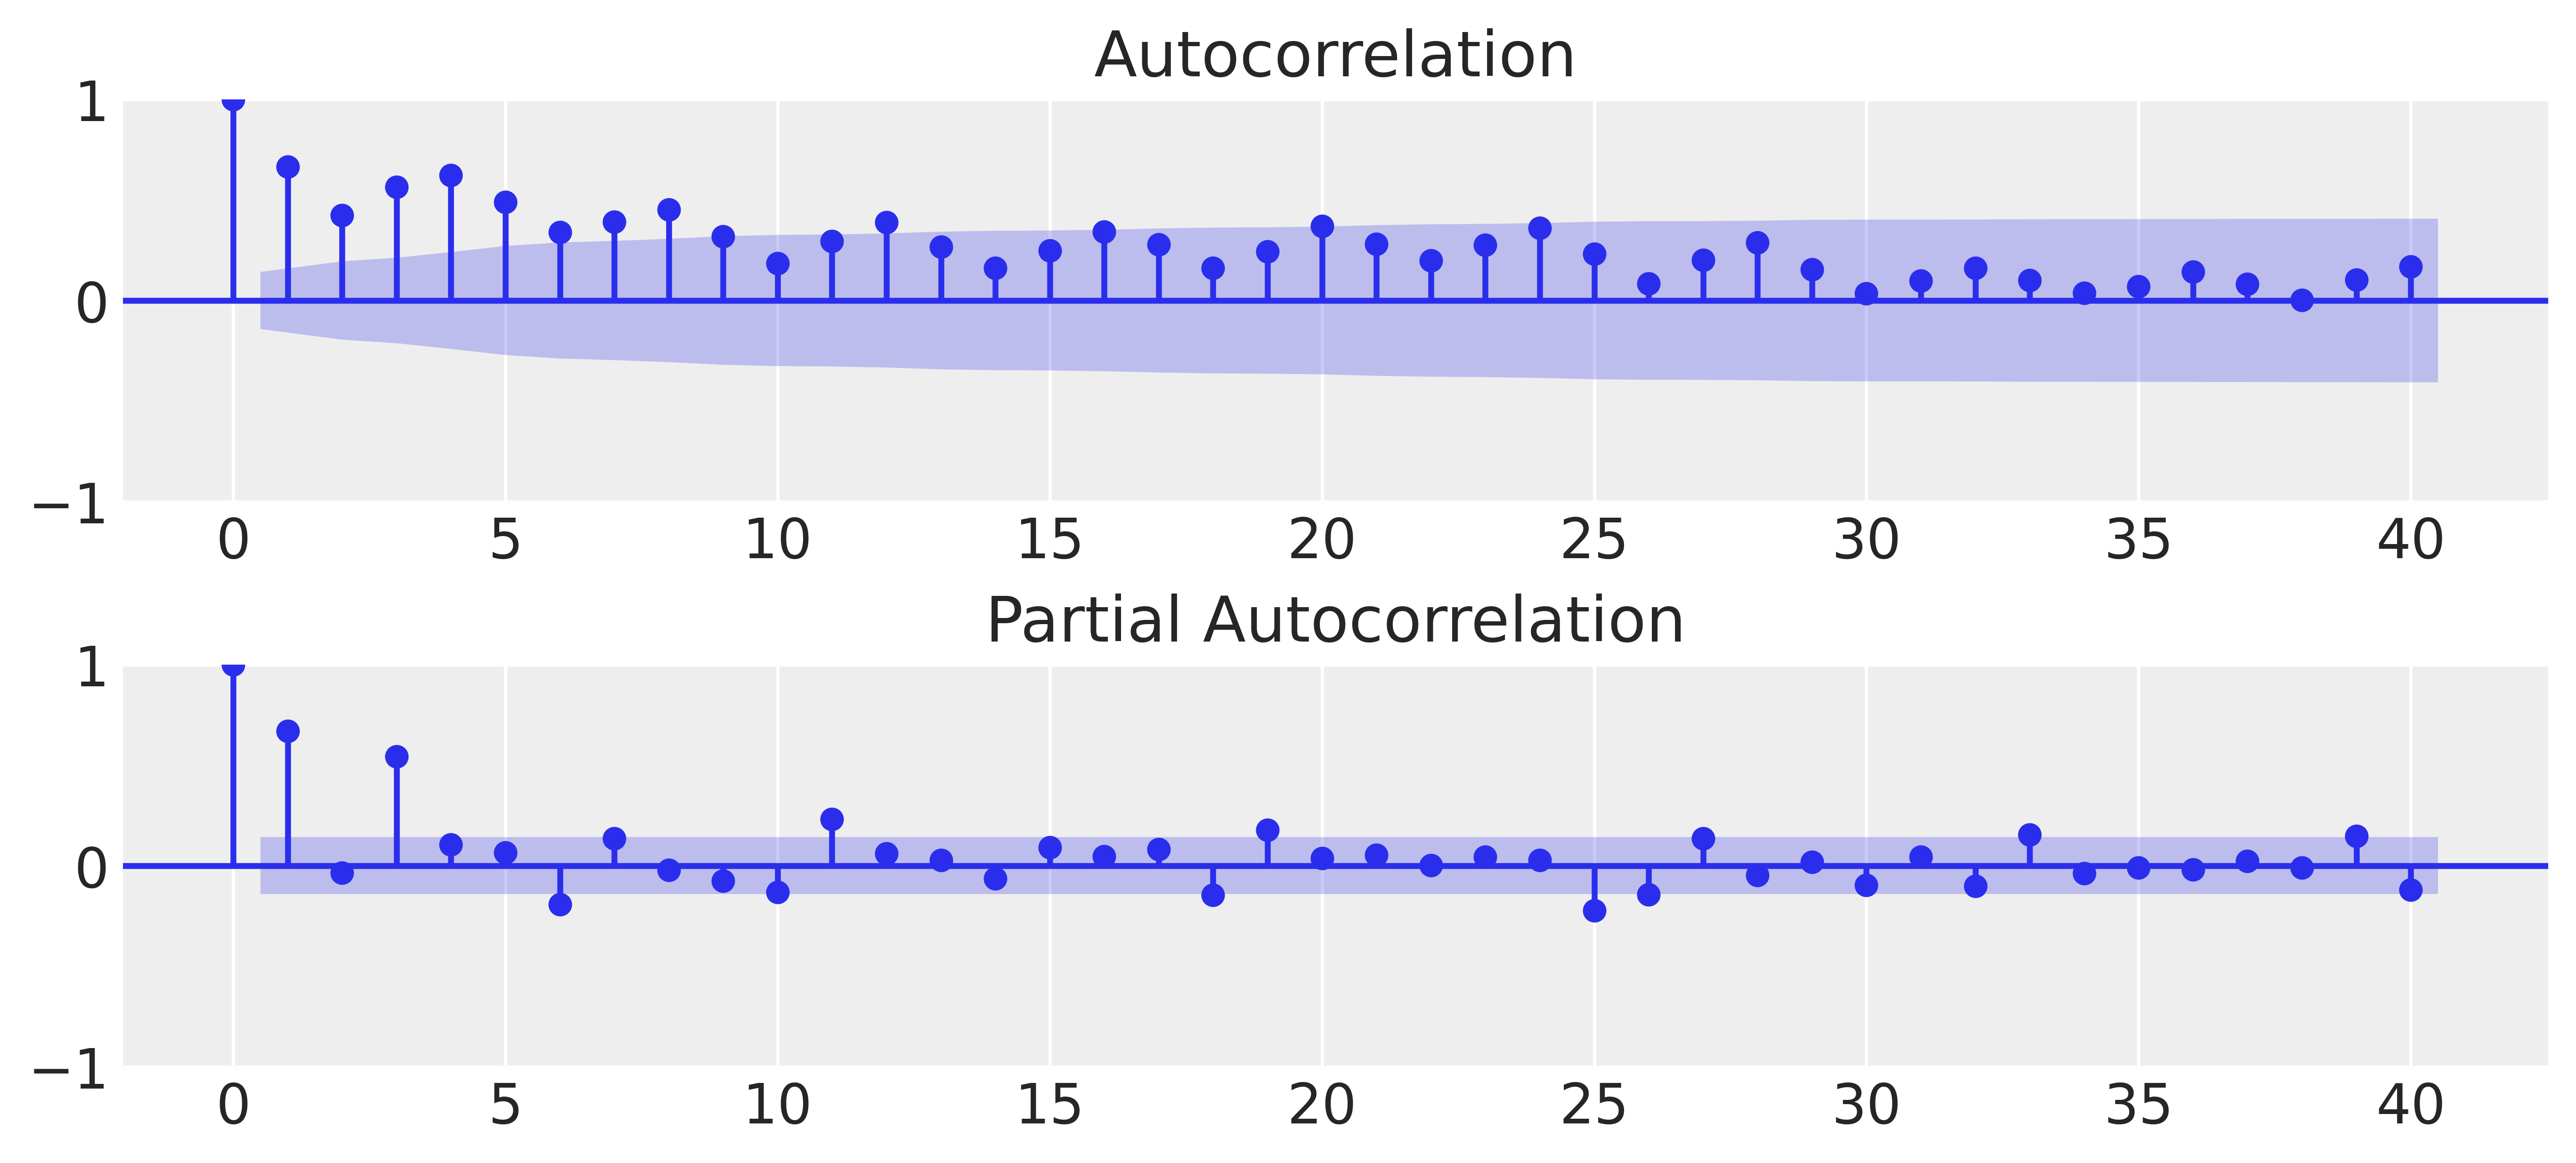

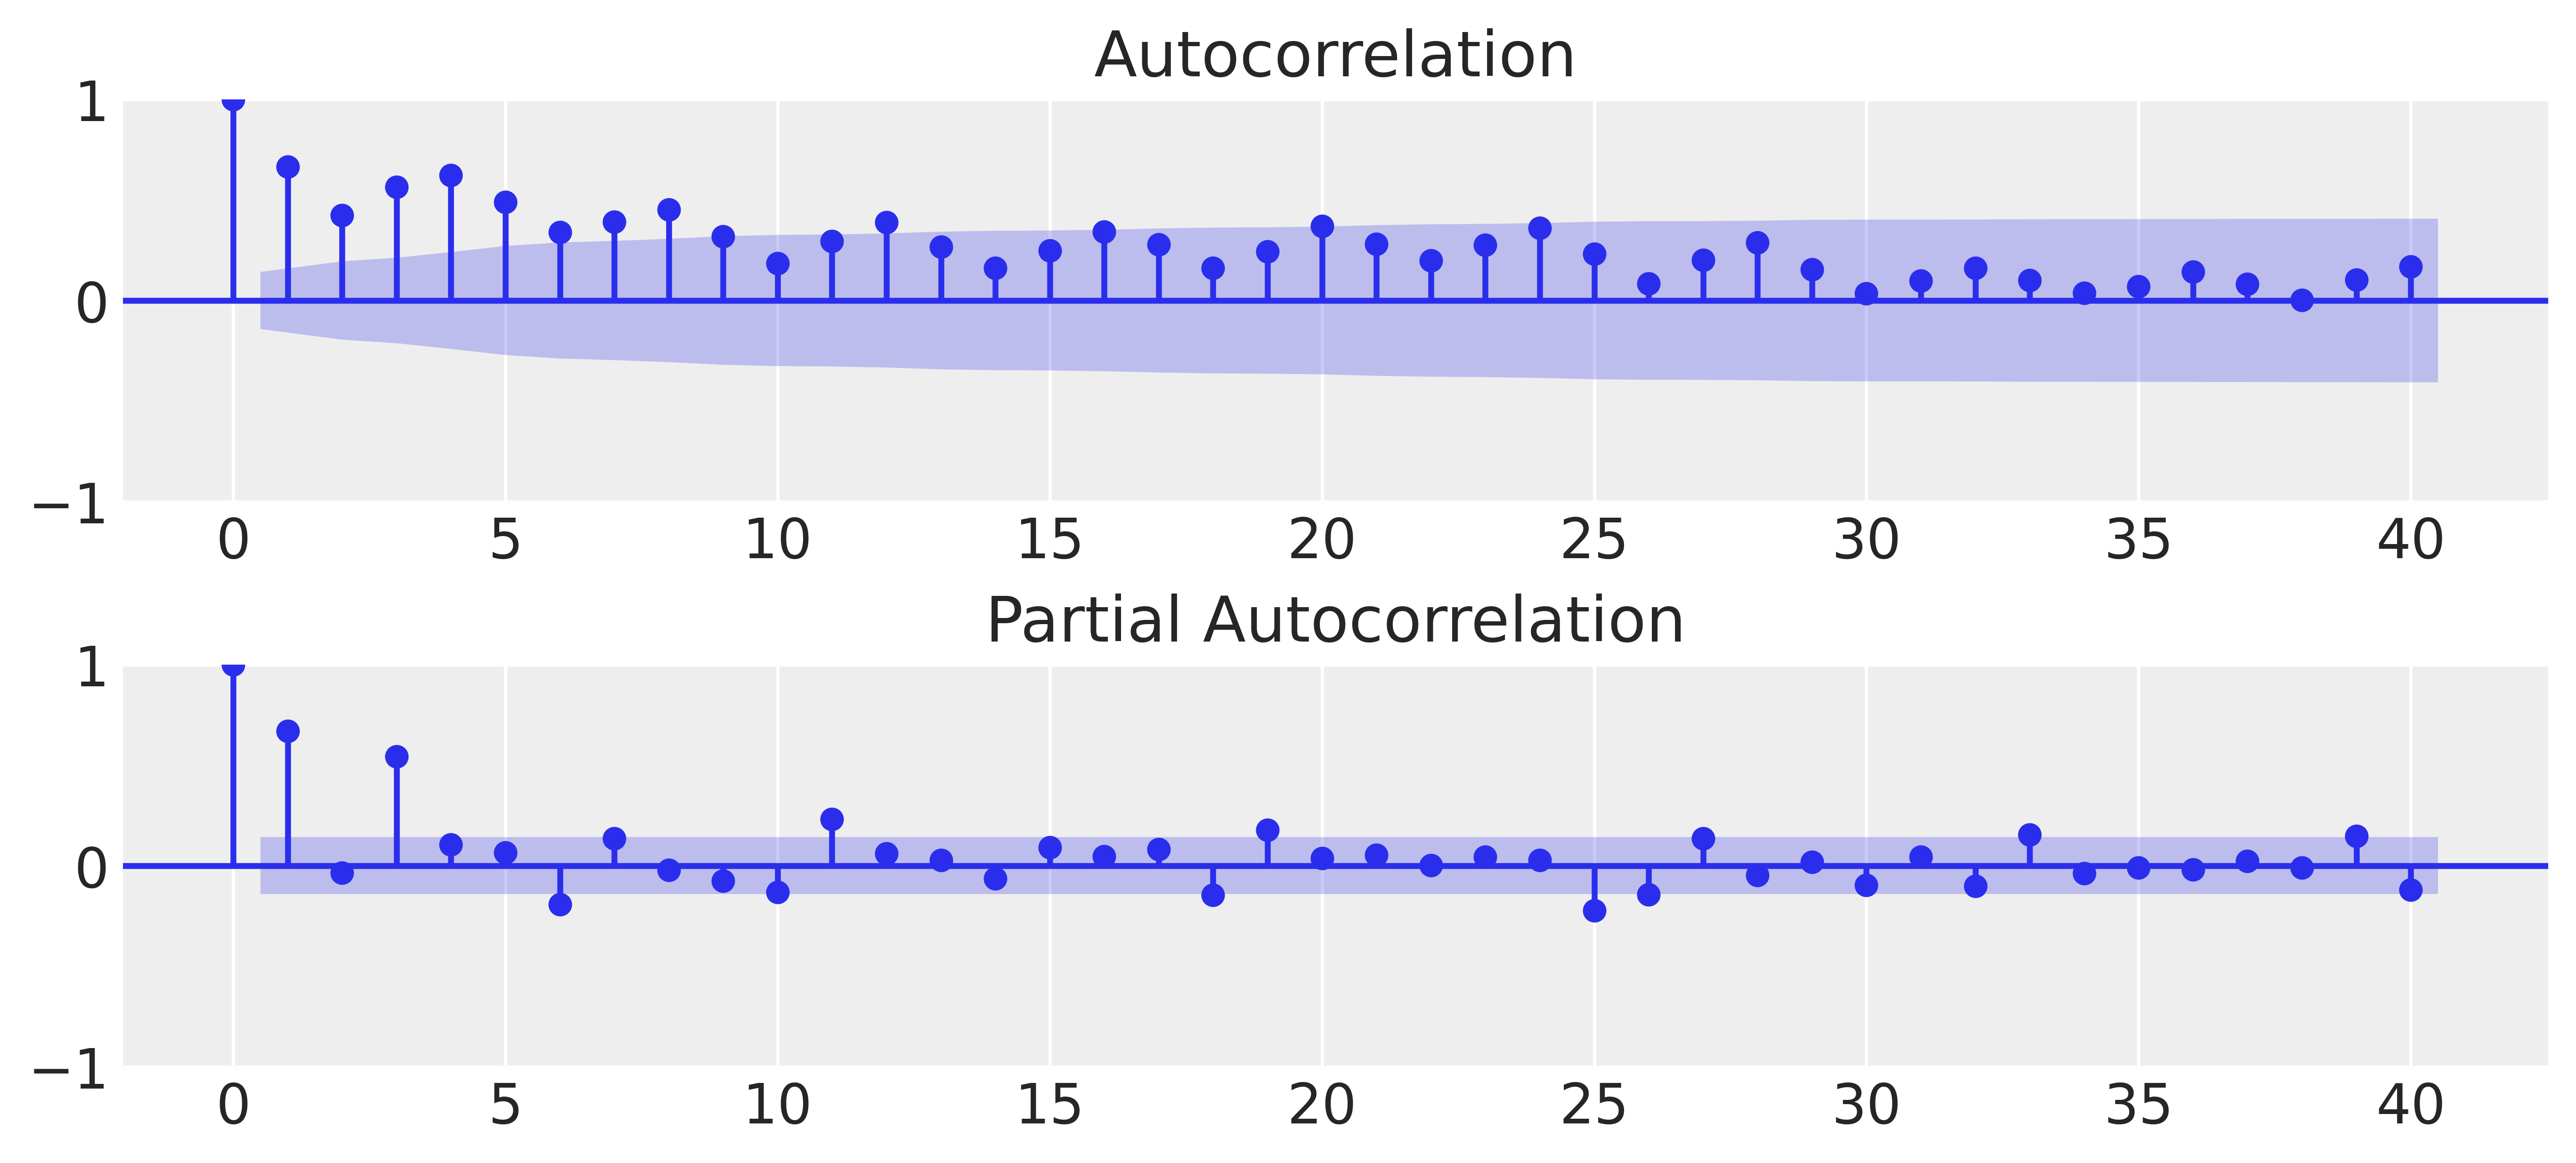

In [5]:
# plot acf and pacf
fig, ax = plt.subplots(2, 1, figsize=(9, 4), dpi=300)
sm.graphics.tsa.plot_acf(inf, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(inf, lags=40, ax=ax[1])

In [5]:
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

                               SARIMAX Results                                
Dep. Variable:               CPIAUCNS   No. Observations:                  191
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -448.685
Date:                Sun, 23 Apr 2023   AIC                            903.370
Time:                        00:44:25   BIC                            913.127
Sample:                    04-01-1971   HQIC                           907.322
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9785      0.015     64.545      0.000       0.949       1.008
ma.L1         -0.6342      0.057    -11.073      0.000      -0.747      -0.522
sigma2         6.3682      0.323     19.695      0.0

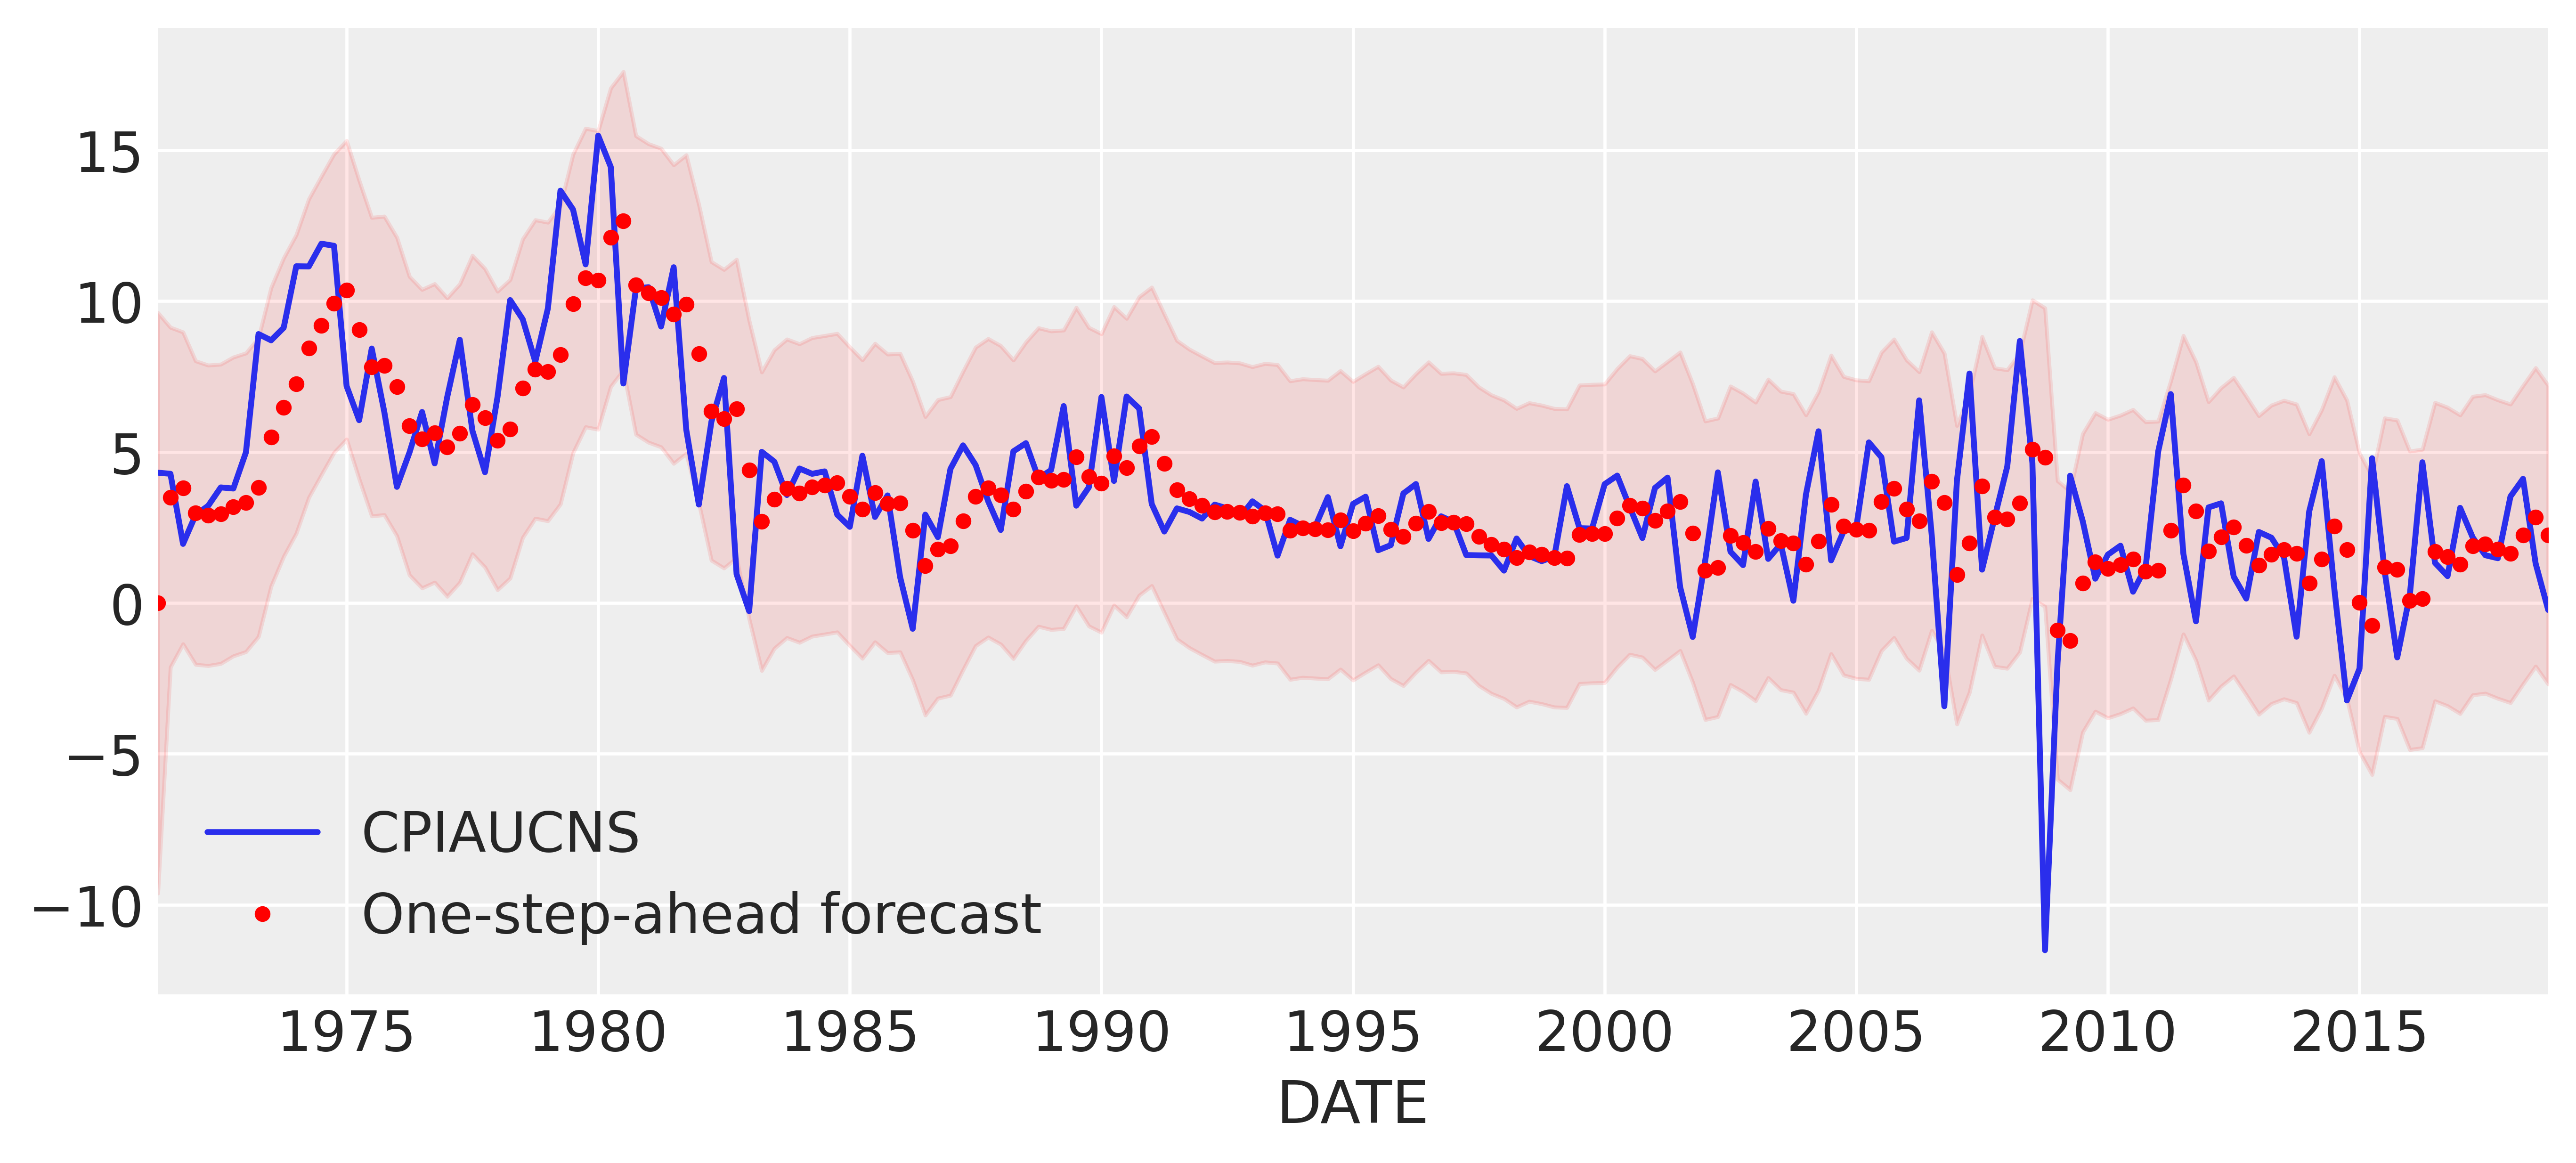

In [6]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci["lower CPIAUCNS"]
upper = predict_mle_ci["upper CPIAUCNS"]

# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_mle_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

In [7]:
from arma_inference import Loglike

In [8]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

In [10]:
# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. Here we are using the same model instance
# created earlier for MLE analysis (we could also create a new model
# instance if we preferred)
loglike = Loglike(mod)

with pm.Model() as m:
    # Priors
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)
    maL1 = pm.Uniform("ma.L1", -0.99, 0.99)
    sigma2 = pm.InverseGamma("sigma2", 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike, observed=theta)

    # Draw samples
    trace = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
        target_accept=0.95,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 470 seconds.


/var/folders/pr/kpm1jr112s94x5wrxyqdpx_w0000gn/T/ipykernel_80055/3272355327.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(trace, var_names=["ar.L1", "ma.L1", "sigma2"], combined=True)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

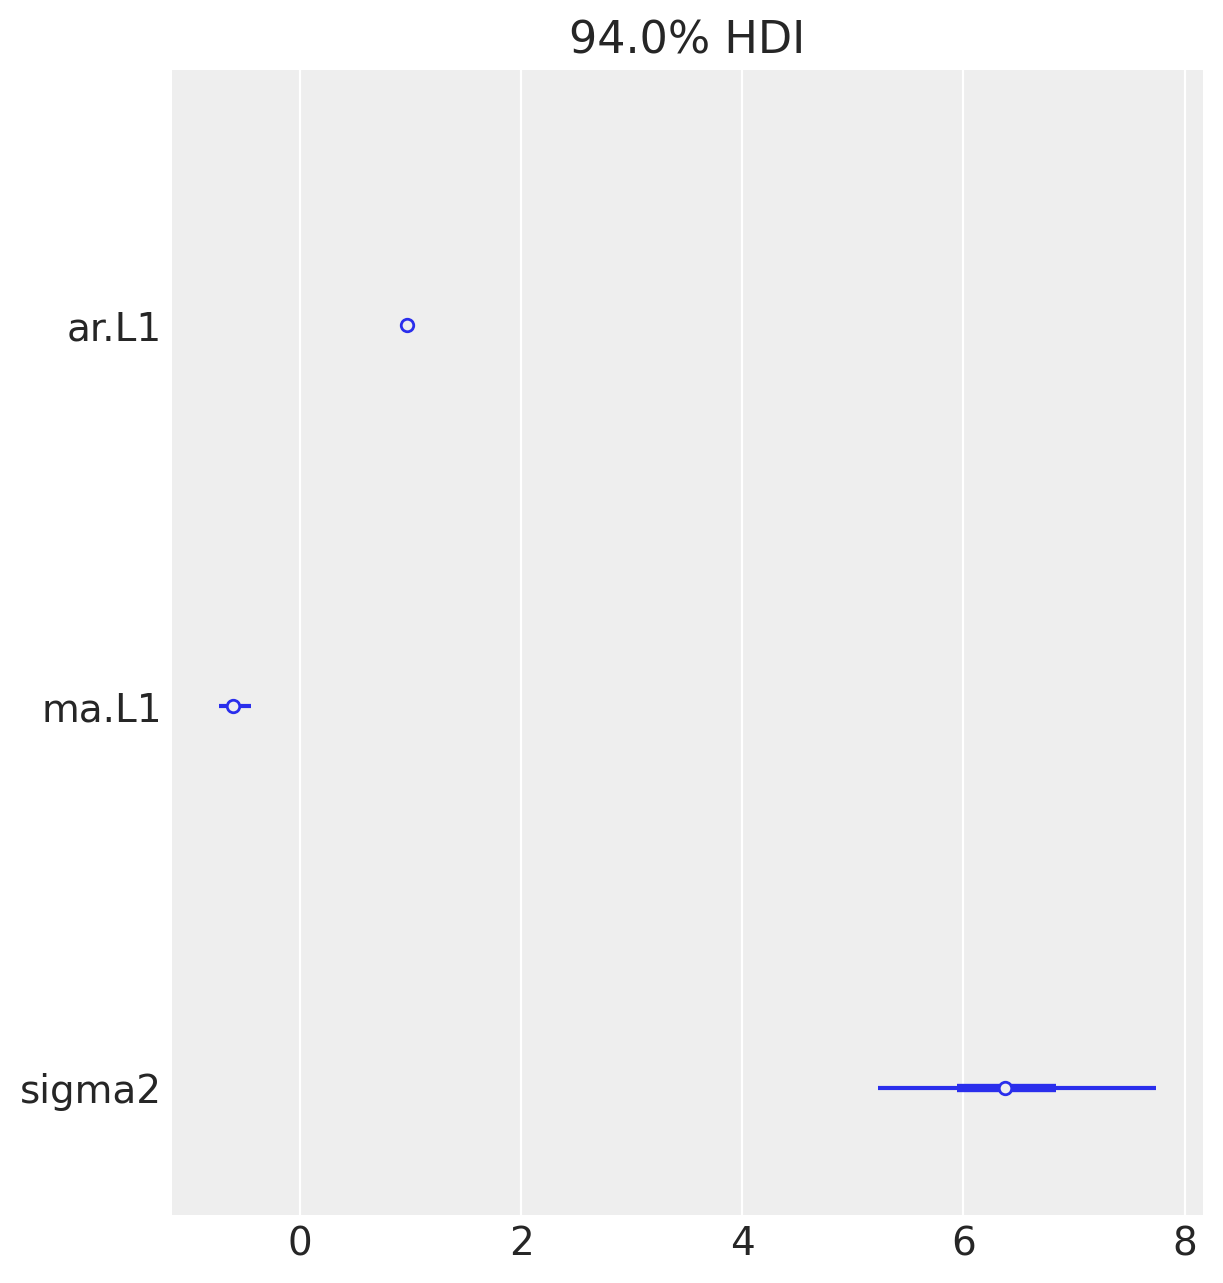

In [ ]:
pm.forestplot(trace, var_names=["ar.L1", "ma.L1", "sigma2"], combined=True)

array([[<Axes: title={'center': 'ar.L1'}>,
        <Axes: title={'center': 'ar.L1'}>],
       [<Axes: title={'center': 'ma.L1'}>,
        <Axes: title={'center': 'ma.L1'}>],
       [<Axes: title={'center': 'sigma2'}>,
        <Axes: title={'center': 'sigma2'}>]], dtype=object)

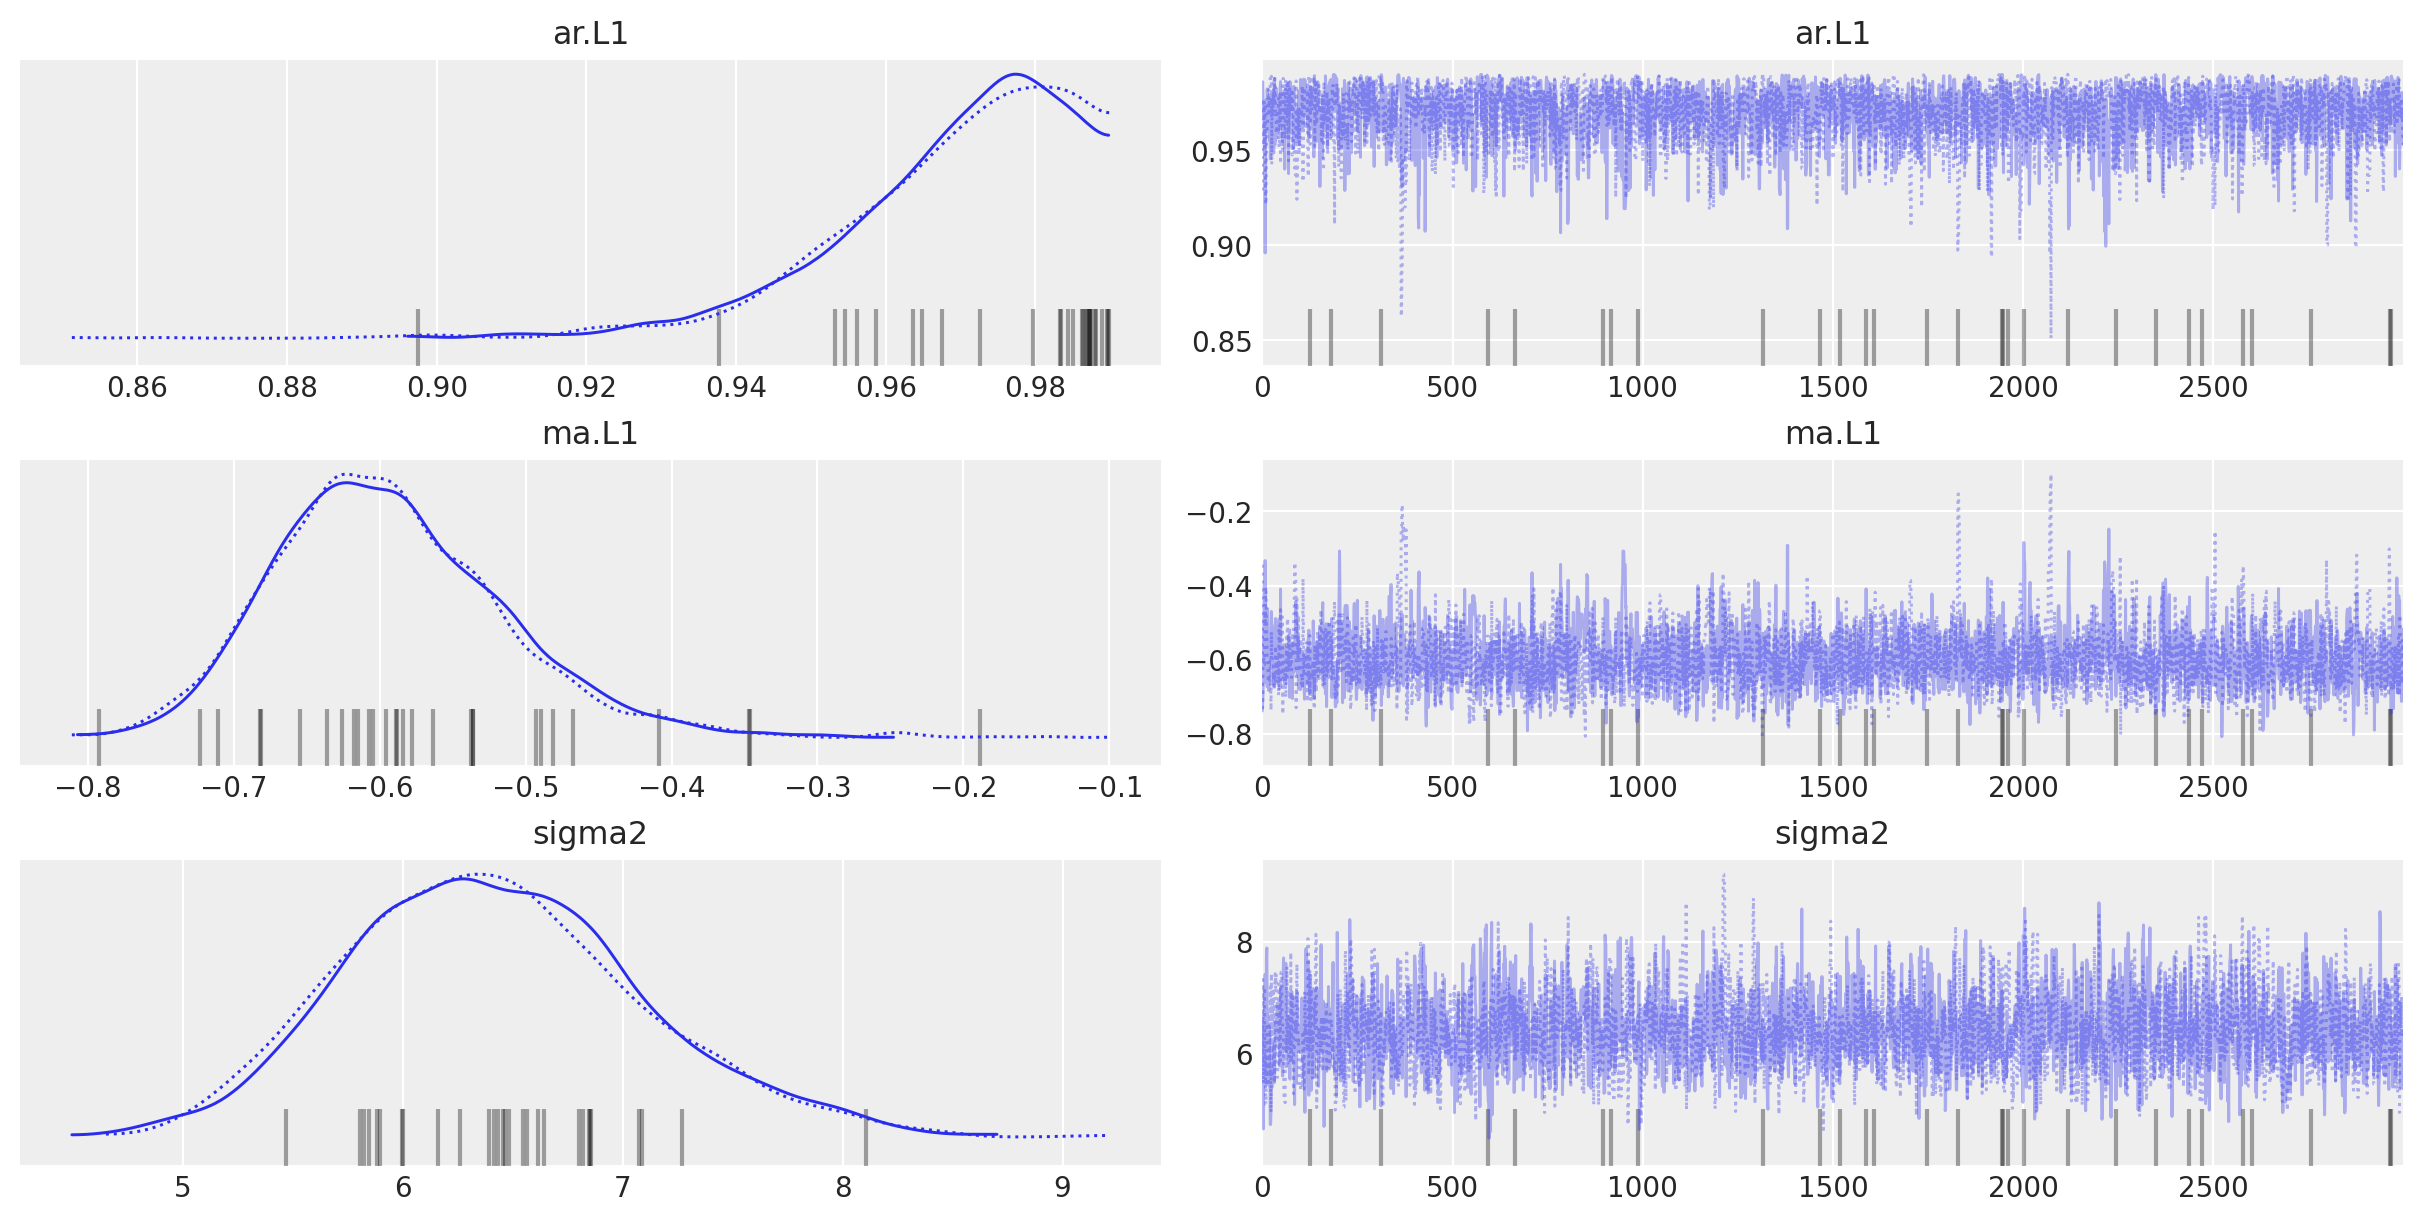

In [ ]:
az.plot_trace(trace)

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar.L1,0.969,0.015,0.943,0.990,0.000,0.000,1770.0,2178.0,1.0
ma.L1,-0.593,0.081,-0.735,-0.442,0.002,0.002,1769.0,1519.0,1.0
sigma2,6.416,0.674,5.224,7.745,0.015,0.010,2116.0,2432.0,1.0


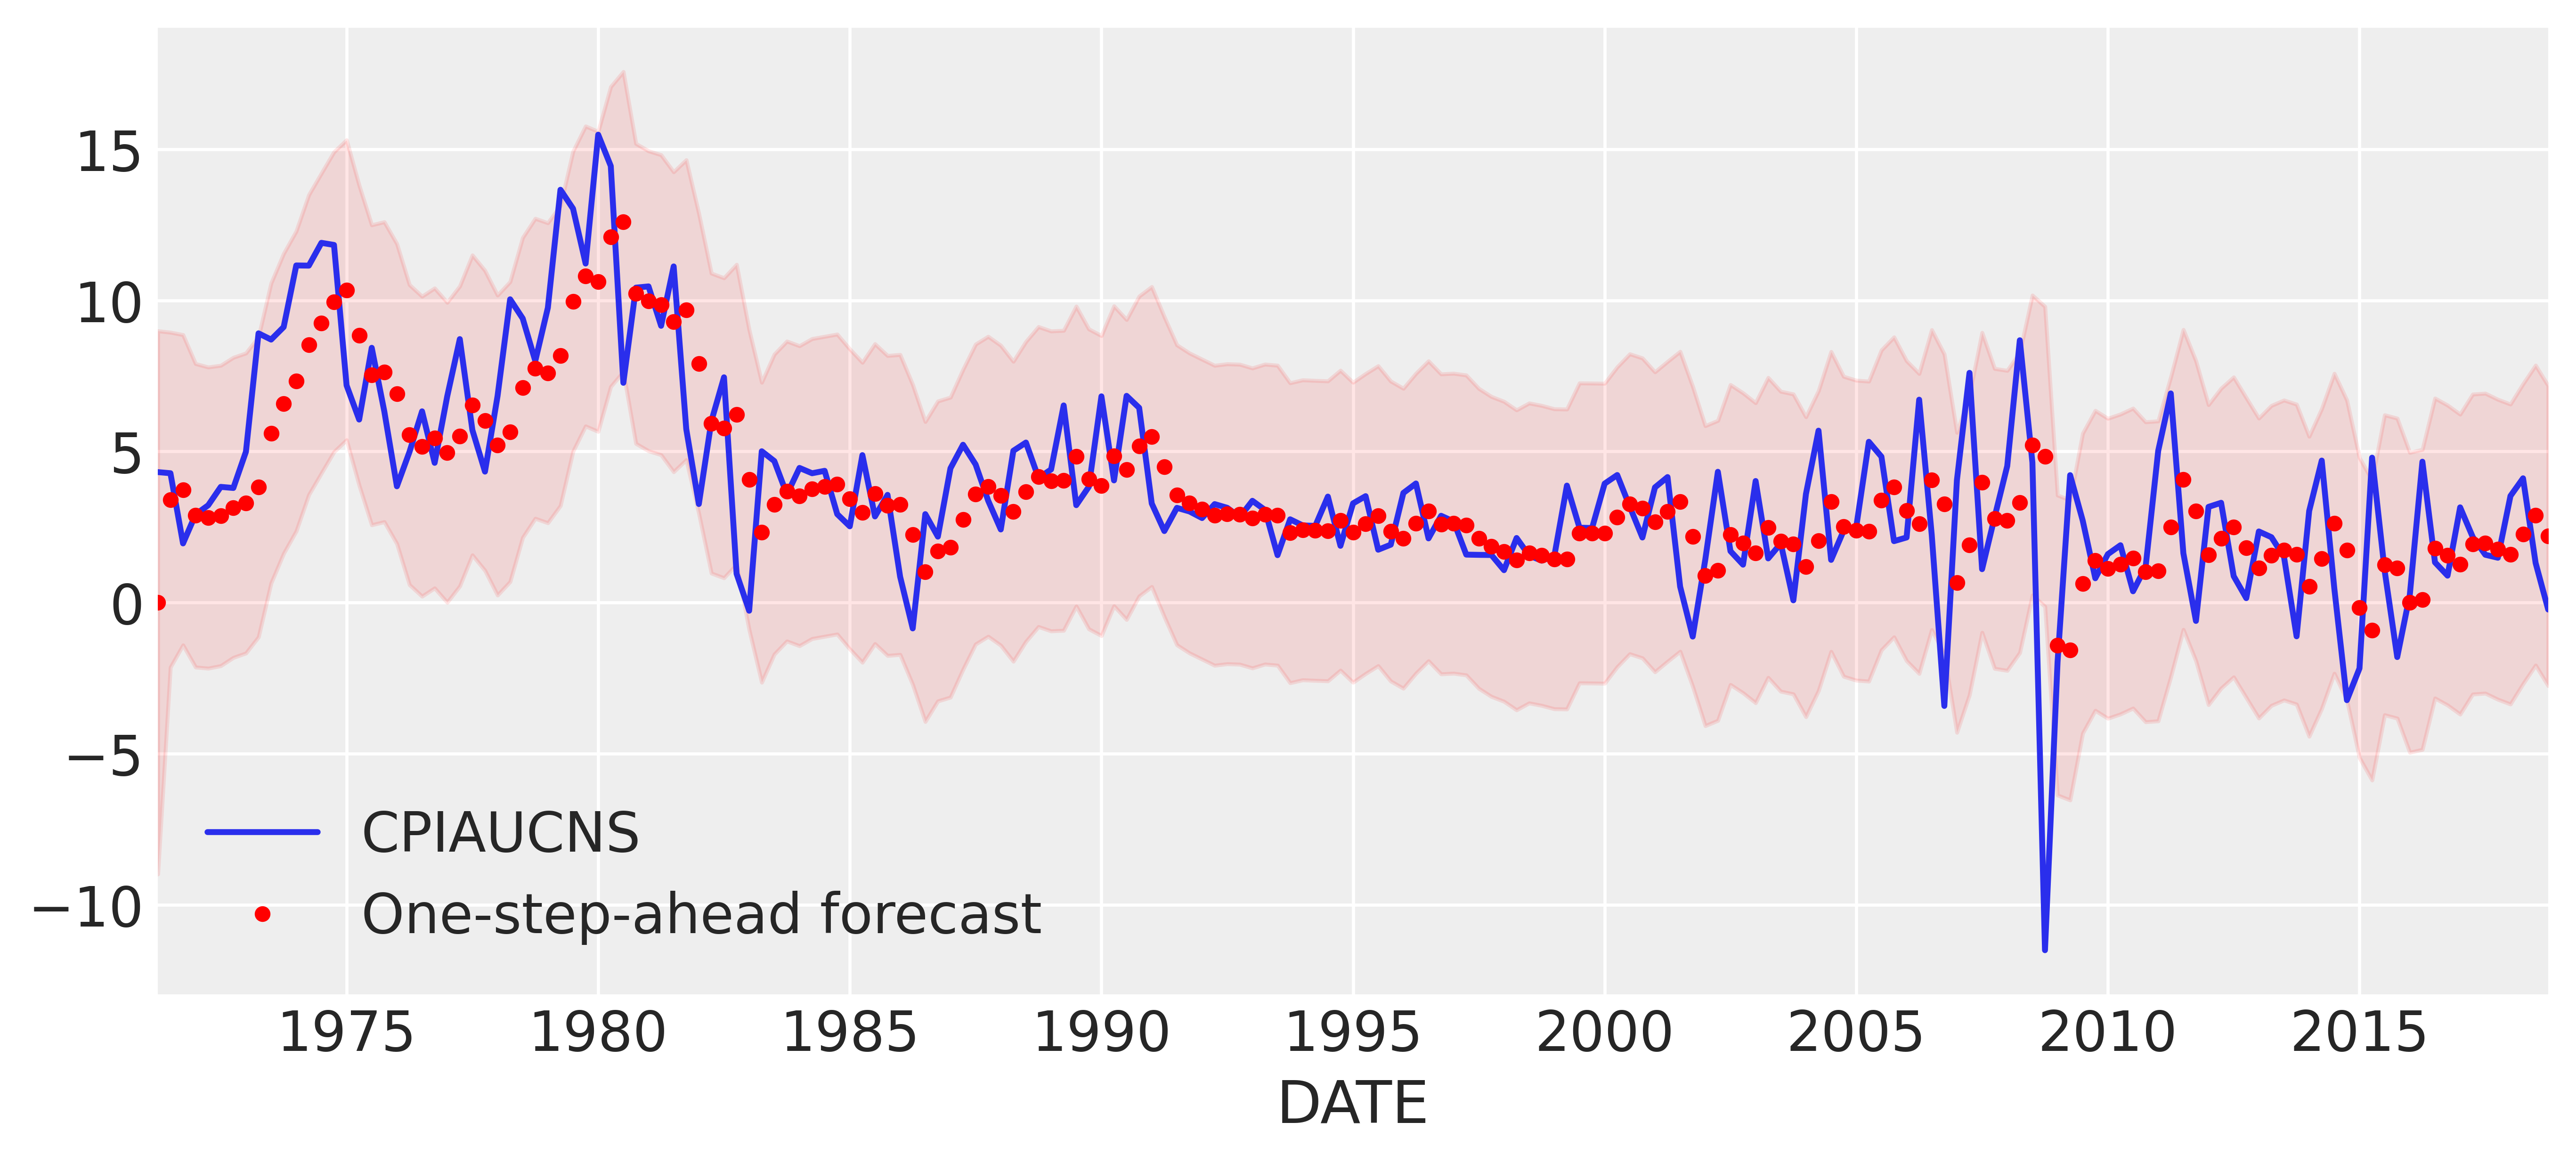

In [14]:
# Retrieve the posterior means
params = pm.summary(trace)["mean"].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci["lower CPIAUCNS"]
upper = predict_bayes_ci["upper CPIAUCNS"]

# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_bayes_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()